In [2]:
# Install required library
!pip install textblob

import pandas as pd
from textblob import TextBlob

# Simulated support ticket dataset
data = {
    "ticket_id": ["T001", "T002", "T003", "T004", "T005", "T006", "T007"],
    "message": [
        "My account is locked. I’ve tried resetting my password twice. Please fix this ASAP!",
        "Just curious — will you be adding dark mode anytime soon?",
        "Love the new interface, but the app crashes after 10 minutes of use.",
        "Payment failed again. I’ve retried three times. Can someone fix this now?",
        "App is great overall. One thing: the search bar is laggy.",
        "Your support team was super helpful today!",
        "I’ve been charged twice for my subscription. Need this refunded immediately."
    ]
}

df = pd.DataFrame(data)

# Sentiment analysis
df["sentiment_score"] = df["message"].apply(lambda x: TextBlob(x).sentiment.polarity)
df["sentiment_label"] = df["sentiment_score"].apply(
    lambda x: "Positive" if x > 0.2 else "Negative" if x < -0.2 else "Neutral"
)

# Urgency detection via simple keywords
urgent_keywords = ["asap", "now", "immediately", "urgent", "help", "fix this", "need this", "retried", "locked"]
df["is_urgent"] = df["message"].str.lower().apply(lambda x: any(kw in x for kw in urgent_keywords))

# Show results
df[["ticket_id", "message", "sentiment_label", "is_urgent"]]


,ticket_id,message,sentiment_label,is_urgent
0,T001,My account is locked. I’ve tried resetting my ...,Neutral,True
1,T002,Just curious — will you be adding dark mode an...,Neutral,False
2,T003,"Love the new interface, but the app crashes af...",Positive,False
3,T004,Payment failed again. I’ve retried three times...,Negative,True
4,T005,App is great overall. One thing: the search ba...,Positive,False
5,T006,Your support team was super helpful today!,Positive,True
6,T007,I’ve been charged twice for my subscription. N...,Neutral,True


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


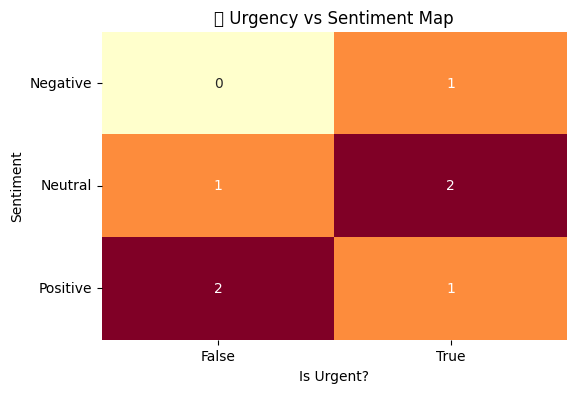

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group sentiment + urgency
summary = df.groupby(['sentiment_label', 'is_urgent']).size().reset_index(name='count')

# Pivot for heatmap
pivot_table = summary.pivot(index='sentiment_label', columns='is_urgent', values='count').fillna(0)

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(pivot_table, annot=True, fmt="g", cmap="YlOrRd", cbar=False)
plt.title("🔥 Urgency vs Sentiment Map")
plt.xlabel("Is Urgent?")
plt.ylabel("Sentiment")
plt.xticks([0.5, 1.5], ['False', 'True'])
plt.yticks(rotation=0)
plt.show()


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Vectorize messages
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df["message"])

# Step 2: Run KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df["theme_cluster"] = kmeans.fit_predict(X)

# Step 3: Top keywords per cluster
def get_top_keywords(n_terms=5):
    keywords = {}
    centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()
    for i in range(3):
        keywords[i] = [terms[ind] for ind in centroids[i, :n_terms]]
    return keywords

themes = get_top_keywords()

# Display cluster + theme keywords
print("🧵 Top Keywords per Theme:")
for cluster_id, keywords in themes.items():
    print(f"Cluster {cluster_id}: {', '.join(keywords)}")

# Show labeled ticket table
df[["ticket_id", "message", "theme_cluster"]]


🧵 Top Keywords per Theme:
Cluster 0: app, support, team, super, helpful
Cluster 1: subscription, charged, need, refunded, immediately
Cluster 2: fix, ve, retried, times, payment


,ticket_id,message,theme_cluster
0,T001,My account is locked. I’ve tried resetting my ...,2
1,T002,Just curious — will you be adding dark mode an...,0
2,T003,"Love the new interface, but the app crashes af...",0
3,T004,Payment failed again. I’ve retried three times...,2
4,T005,App is great overall. One thing: the search ba...,0
5,T006,Your support team was super helpful today!,0
6,T007,I’ve been charged twice for my subscription. N...,1


In [5]:
from collections import Counter

# Total tickets
total_tickets = len(df)

# Sentiment breakdown
sentiment_counts = df["sentiment_label"].value_counts().to_dict()

# Urgency breakdown
urgent_counts = df["is_urgent"].value_counts().to_dict()

# Theme cluster mapping (name based on top keywords)
theme_map = {
    0: "General Feedback / Feature Requests",
    1: "Billing & Subscription Issues",
    2: "Access or Tech Failures"
}

# Map themes
df["theme_label"] = df["theme_cluster"].map(theme_map)

# Top 3 themes by count
top_themes = df["theme_label"].value_counts().head(3).to_dict()

# 🔥 Display a clean summary block
print("📬 INBOX WHISPERER – SMART SUMMARY")
print("────────────────────────────────────")
print(f"🧾 Total Tickets Analyzed: {total_tickets}\n")

print("🧠 Sentiment Breakdown:")
for k, v in sentiment_counts.items():
    print(f"  • {k}: {v}")

print("\n⚡ Urgency:")
print(f"  • Urgent: {urgent_counts.get(True, 0)}")
print(f"  • Not Urgent: {urgent_counts.get(False, 0)}")

print("\n🧵 Top Ticket Themes:")
for theme, count in top_themes.items():
    print(f"  • {theme} → {count} tickets")

print("\n🧩 Recommended Next Action:")
if sentiment_counts.get("Negative", 0) > 0 and urgent_counts.get(True, 0) > 0:
    print("  ➤ Prioritize urgent tickets in Billing & Access clusters.")
elif sentiment_counts.get("Positive", 0) > sentiment_counts.get("Negative", 0):
    print("  ➤ Consider collecting testimonials from happy users.")
else:
    print("  ➤ Monitor support trends for repeat patterns.")


📬 INBOX WHISPERER – SMART SUMMARY
────────────────────────────────────
🧾 Total Tickets Analyzed: 7

🧠 Sentiment Breakdown:
  • Neutral: 3
  • Positive: 3
  • Negative: 1

⚡ Urgency:
  • Urgent: 4
  • Not Urgent: 3

🧵 Top Ticket Themes:
  • General Feedback / Feature Requests → 4 tickets
  • Access or Tech Failures → 2 tickets
  • Billing & Subscription Issues → 1 tickets

🧩 Recommended Next Action:
  ➤ Prioritize urgent tickets in Billing & Access clusters.


In [10]:
from textblob import TextBlob

# Urgent keyword list (you can expand this)
urgent_keywords = ["asap", "urgent", "immediately", "fix this", "now", "help", "refunded", "locked", "payment failed"]

def analyze_message(message):
    # Sentiment polarity
    polarity = TextBlob(message).sentiment.polarity
    if polarity > 0.2:
        sentiment = "Positive"
        color = "🟢"
    elif polarity < -0.2:
        sentiment = "Negative"
        color = "🔴"
    else:
        sentiment = "Neutral"
        color = "🟡"

    # Urgency check
    urgency = any(kw in message.lower() for kw in urgent_keywords)
    urgency_flag = "⚠️ Urgent" if urgency else "🕓 Not Urgent"

    # Display output
    print("─────────────────────────────")
    print(f"{color} Sentiment: {sentiment}")
    print(f"{urgency_flag}")
    print("─────────────────────────────")

# 🧪 Try it out:
test_input = input("📥 Enter a customer message: ")
analyze_message(test_input)


📥 Enter a customer message: This makes me angry, need urgent support!
─────────────────────────────
🔴 Sentiment: Negative
⚠️ Urgent
─────────────────────────────
